## In this notebook the police-department-incidents dataset will be explored

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation

import datetime
import seaborn as sns
import geopandas as gp
from shapely.geometry import Point
import geoplot as gplt
import geoplot.crs as gcrs
import cartopy
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

In [2]:
incidents = pd.read_csv('../data/sf-police-calls-for-service-and-incidents/police-department-incidents.csv') 

In [3]:
## general information about the "incidents" dataset

In [4]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215024 entries, 0 to 2215023
Data columns (total 13 columns):
IncidntNum    int64
Category      object
Descript      object
DayOfWeek     object
Date          object
Time          object
PdDistrict    object
Resolution    object
Address       object
X             float64
Y             float64
Location      object
PdId          int64
dtypes: float64(2), int64(2), object(9)
memory usage: 219.7+ MB


The incidents dataframe has over 2M rows and a total of 13 columns. IncidntNum and pdId columns are integers, X, Y columns are of type float, and the rest of the columns are of type string. We will convert Date and Time columns to datetime objects.

The X and Y columns provide longitude and latitude location of the incident which we will use to create maps of spatial distribution of incidents. For the purpose of this presentation, the maps will be at neighborhood resolution. Therefore, we will not use the Address, Location, and PdDistrict columns. 

## Missing values in incidents dataset

In [5]:
incidents.isna().sum()

IncidntNum    0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    1
Resolution    0
Address       0
X             0
Y             0
Location      0
PdId          0
dtype: int64

There is only one missing value in the PdDistrict column. We will drop the row associated with this missing value since there's only one instance of it. 

In [6]:
incidents = incidents.dropna()

## IncidntNum and PdId

We will check these two columns to find unique identifiers associated with each incident.

In [7]:
print ('Number of rows in incidents dataset:' , len(incidents))
print ('Number of unique IncidntNum:' , len(incidents['IncidntNum'].unique()))
print ('Number of unique PdId:' , len(incidents['PdId'].unique()))

Number of rows in incidents dataset: 2215023
Number of unique IncidntNum: 1746913
Number of unique PdId: 2215023


We see that the incident number is not unique but PdId is unique. Let's look at an instance of incidents where multiple PdIds share the same incident number.

In [8]:
incidents_by_incidentNum = incidents.groupby('IncidntNum')['PdId'].count().sort_values(ascending = False).reset_index()

In [9]:
incidents.loc[incidents['IncidntNum'] == incidents_by_incidentNum['IncidntNum'].values[0]][['IncidntNum','Category','Descript','Resolution']]

,IncidntNum,Category,Descript,Resolution
21026,180187811,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)","ARREST, BOOKED"
21027,180187811,FORGERY/COUNTERFEITING,"CHECKS OR LEGAL INSTRUMENTS, UTTERING FORGED","ARREST, BOOKED"
21028,180187811,FORGERY/COUNTERFEITING,"CHECKS, MAKE OR PASS FICTITIOUS","ARREST, BOOKED"
21029,180187811,FORGERY/COUNTERFEITING,"CHECKS, POSSESSION WITH INTENT TO PASS","ARREST, BOOKED"
21030,180187811,FRAUD,"FORGERY, CREDIT CARD","ARREST, BOOKED"
21031,180187811,FORGERY/COUNTERFEITING,"FORGERY, DRIVERS LICENSE OR ID-CARD","ARREST, BOOKED"
21032,180187811,FORGERY/COUNTERFEITING,"FORGERY, POSSESSION DRIVERS LICENSE OR ID-CARD","ARREST, BOOKED"
21033,180187811,FORGERY/COUNTERFEITING,"FORGERY, GOVERNMENT OR CORPORATE SEALS","ARREST, BOOKED"
21034,180187811,FORGERY/COUNTERFEITING,"FORGERY, NOTES","ARREST, BOOKED"
21035,180187811,FRAUD,"ACCESS CARD INFORMATION, THEFT OF","ARREST, BOOKED"


### Note:
We see that all these rows belong to one incident with different types of incident categories and descriptions. For the purpose of this analysis, when counting the number of incidents, multiple incidents with the same incident number and the same category and the same time stamp and the same X-Y location are treated counted as one unique incident. For example, in the example shown above, all FORGERY/COUNTERFEITING incidents with incident number '180187811' are counted as one FORGERY/COUNTERFEITING incident and all FRAUD incidents with incident number '180187811' are counted as one FRAUD incident.

## Unique Incidents

We will combine Date and Time columns and convert that to datetime type. We need this to identify unique incidents in each category (explained in the note above).

In [10]:
incidents['Date Time'] = pd.to_datetime(pd.to_datetime(incidents['Date']).dt.date.astype(str) + ' ' + incidents['Time'])

In [11]:
incidents.drop(['Date','Time'], axis = 1, inplace = True)

Now let's group incidents by their incident number, category, timestamp, and X Y location to create the unique_incident dataframe:

In [12]:
unique_incidents = incidents.groupby(['IncidntNum', 'Date Time',
                                                     'Category','DayOfWeek','X','Y','Resolution'])['PdId'].count().sort_values(ascending = False).reset_index()
unique_incidents.rename(columns = {'PdId':'Count'}, inplace = True)

In [13]:
unique_incidents

,IncidntNum,Date Time,Category,DayOfWeek,X,Y,Resolution,Count
0,140135145,2014-02-15 04:48:00,WEAPON LAWS,Saturday,-122.423286,37.740219,"ARREST, BOOKED",13
1,160629623,2016-08-04 22:30:00,DRUG/NARCOTIC,Thursday,-122.408771,37.780136,"ARREST, BOOKED",10
2,180187811,2018-03-11 21:15:00,FORGERY/COUNTERFEITING,Sunday,-122.406844,37.789226,"ARREST, BOOKED",10
3,150793363,2015-09-09 22:48:00,DRUG/NARCOTIC,Wednesday,-122.410066,37.774991,"ARREST, BOOKED",9
4,121004501,2012-12-13 16:24:00,DRUG/NARCOTIC,Thursday,-122.456499,37.724695,"ARREST, BOOKED",9
...,...,...,...,...,...,...,...,...
2057730,130426619,2013-05-23 18:00:00,OTHER OFFENSES,Thursday,-122.393876,37.727623,"ARREST, BOOKED",1
2057731,130426619,2013-05-23 18:00:00,VANDALISM,Thursday,-122.393876,37.727623,"ARREST, BOOKED",1
2057732,130426619,2013-05-23 18:00:00,WARRANTS,Thursday,-122.393876,37.727623,"ARREST, BOOKED",1
2057733,130426625,2013-05-23 15:45:00,OTHER OFFENSES,Thursday,-122.483986,37.730991,NONE,1


We see that instead of 2215023 incidents which is the length of the original dataset, we now have 2057726 unique incidents. We will use these unique incidents for the rest of the analysis.
Let's see which categories are most common between these incidents.

## Incident Categories and Descripts
Let's look at a list of different incident categories that exist in this dataset:

In [14]:
unique_incidents['Category'].unique()

array(['WEAPON LAWS', 'DRUG/NARCOTIC', 'FORGERY/COUNTERFEITING', 'FRAUD',
       'OTHER OFFENSES', 'ASSAULT', 'PROSTITUTION', 'WARRANTS',
       'SEX OFFENSES, FORCIBLE', 'VANDALISM', 'LARCENY/THEFT',
       'VEHICLE THEFT', 'ROBBERY', 'NON-CRIMINAL', 'BURGLARY',
       'SUSPICIOUS OCC', 'MISSING PERSON', 'DISORDERLY CONDUCT', 'ARSON',
       'KIDNAPPING', 'SUICIDE', 'FAMILY OFFENSES', 'SECONDARY CODES',
       'STOLEN PROPERTY', 'LIQUOR LAWS', 'GAMBLING',
       'DRIVING UNDER THE INFLUENCE', 'TRESPASS', 'EMBEZZLEMENT',
       'LOITERING', 'RECOVERED VEHICLE', 'EXTORTION', 'BAD CHECKS',
       'BRIBERY', 'RUNAWAY', 'DRUNKENNESS', 'SEX OFFENSES, NON FORCIBLE',
       'PORNOGRAPHY/OBSCENE MAT', 'TREA'], dtype=object)

What categories are most common between incidents? 

In [15]:
unique_incidents_by_cat = unique_incidents.groupby(['Category'])['IncidntNum'].count().sort_values(ascending = False).reset_index()
unique_incidents_by_cat.rename(columns = {'IncidntNum':'Count'}, inplace = True)
unique_incidents_by_cat['Percent'] = unique_incidents_by_cat['Count']/unique_incidents_by_cat['Count'].sum()*100

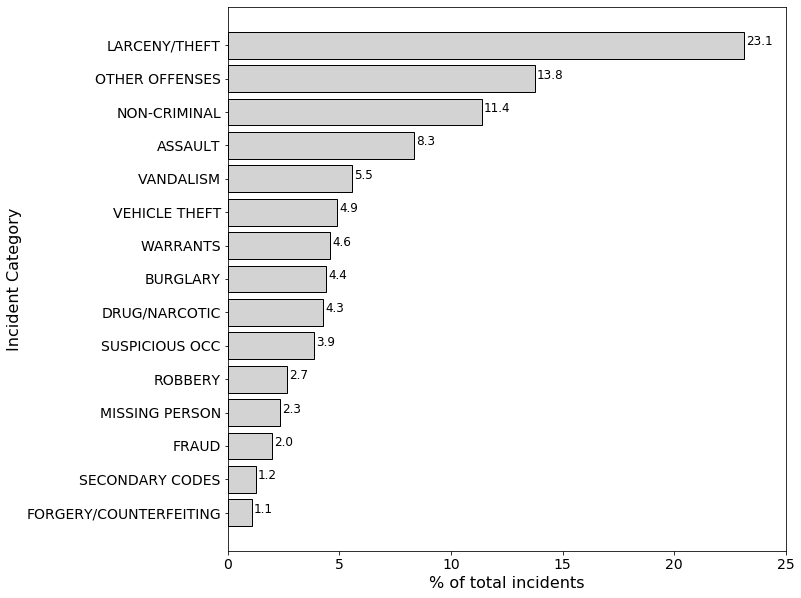

In [16]:
fig = plt.figure(figsize = (10,10))
ax  = fig.add_subplot(1,1,1)
plt.barh(unique_incidents_by_cat['Category'].values[0:15][::-1],
        unique_incidents_by_cat['Percent'].values[0:15][::-1], color = 'lightgray', edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('% of total incidents', fontsize = 16)
plt.ylabel('Incident Category', fontsize = 16)

for i in range(len(unique_incidents_by_cat['Category'].values[0:15][::-1])):
    plt.text(unique_incidents_by_cat['Percent'].values[0:15][::-1][i]+0.1 , i , 
             round(unique_incidents_by_cat['Percent'].values[0:15][::-1][i],1), fontsize = 12)

plt.xlim(0,25)
plt.savefig ('../Plots/incidents/Percent_all_incidents_by_cat.pdf', bbox_inches = 'tight')

About 23% of total incidents are related to Larceny/Theft. 

There are 39 different incident categories in this dataset. To better understand the data and distribution of incidents over time and space, we will define a higher level incident categories which includes three main categories:

- Drug-related Incidents: 'DRUG/NARCOTIC'
- Alchohol-related Incidents: 'LIQUOR LAWS', 'DRUNKENNESS', 'DRIVING UNDER THE INFLUENCE'  
- Property-related Incidents: 'VEHICLE THEFT', 'ROBBERY', 'LARCENY/THEFT', 'VANDALISM','STOLEN PROPERTY','BURGLARY', 'ARSON','RECOVERED VEHICLE' 
- Sexual-related Incidents: 'PROSTITUTION','SEX OFFENSES, FORCIBLE', 'PORNOGRAPHY/OBSCENE MAT','SEX OFFENSES, NON FORCIBLE'   
- Other Violent Incidents: 'ASSAULT', 'KIDNAPPING', 'WEAPON LAWS','SUICIDE',  
- Other Non-Violent Incidents:'NON-CRIMINAL', 'OTHER OFFENSES', 'WARRANTS', 'SECONDARY CODES', 'SUSPICIOUS OCC', 'FRAUD', 'TRESPASS', 'FAMILY OFFENSES', 'MISSING PERSON', 'RUNAWAY', 'DISORDERLY CONDUCT', 'FORGERY/COUNTERFEITING', 'GAMBLING', 'BRIBERY', 'EXTORTION', 'EMBEZZLEMENT',  'BAD CHECKS', 'LOITERING', 'TREA' 

In [17]:
Main_Categories_dict = {'Drug-related Incidents':['DRUG/NARCOTIC'],
                       'Alchohol-related Incidents':['LIQUOR LAWS', 'DRUNKENNESS', 'DRIVING UNDER THE INFLUENCE'],
                       'Property-related Incidents':['VEHICLE THEFT', 'ROBBERY', 'LARCENY/THEFT', 'VANDALISM',
                                                     'STOLEN PROPERTY','BURGLARY', 'ARSON','RECOVERED VEHICLE'],
                       'Sexual-related Incidents':['PROSTITUTION','SEX OFFENSES, FORCIBLE', 'PORNOGRAPHY/OBSCENE MAT',
                                                   'SEX OFFENSES, NON FORCIBLE'],
                       'Other Violent Incidents':['ASSAULT', 'KIDNAPPING', 'WEAPON LAWS','SUICIDE'],
                       'Other Non-Violent Incidents':['NON-CRIMINAL', 'OTHER OFFENSES', 'WARRANTS', 
                                                      'SECONDARY CODES', 'SUSPICIOUS OCC', 'FRAUD', 
                                                      'TRESPASS', 'FAMILY OFFENSES', 'MISSING PERSON', 
                                                      'RUNAWAY', 'DISORDERLY CONDUCT', 'FORGERY/COUNTERFEITING', 
                                                      'GAMBLING', 'BRIBERY', 'EXTORTION', 'EMBEZZLEMENT', 
                                                      'BAD CHECKS', 'LOITERING', 'TREA']}

In [18]:
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Drug-related Incidents']),'Main_Category'] = 'Drug-related Incidents'
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Alchohol-related Incidents']),'Main_Category'] = 'Alchohol-related Incidents'
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Property-related Incidents']),'Main_Category'] = 'Property-related Incidents'
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Sexual-related Incidents']),'Main_Category'] = 'Sexual-related Incidents'
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Other Violent Incidents']),'Main_Category'] = 'Other Violent Incidents'
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Other Non-Violent Incidents']),'Main_Category'] = 'Other Non-Violent Incidents'


In [19]:
unique_incidents_by_main_cat = unique_incidents.groupby(['Main_Category'])['IncidntNum'].count().sort_values(ascending = False).reset_index()
unique_incidents_by_main_cat.rename(columns = {'IncidntNum':'Count'}, inplace = True)
unique_incidents_by_main_cat['Percent'] = unique_incidents_by_main_cat['Count']/unique_incidents_by_main_cat['Count'].sum()*100

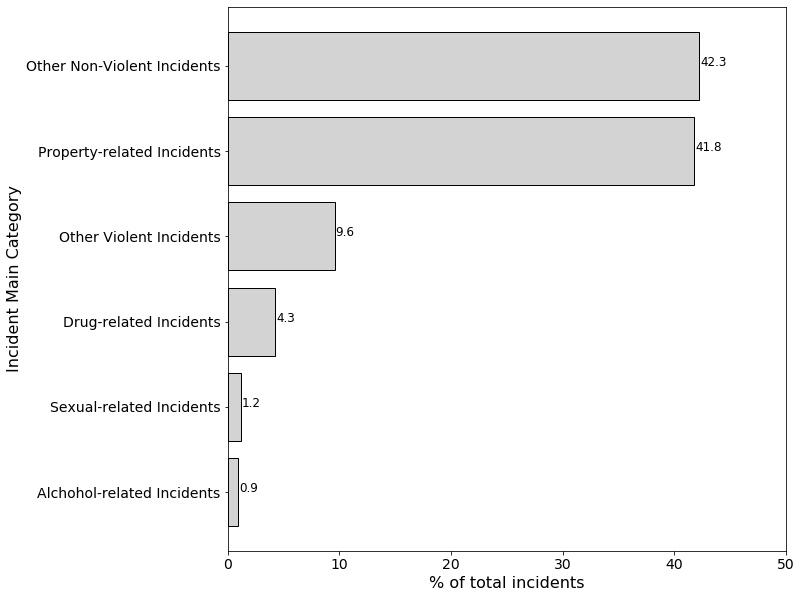

In [20]:
fig = plt.figure(figsize = (10,10))
ax  = fig.add_subplot(1,1,1)
plt.barh(unique_incidents_by_main_cat['Main_Category'].values[::-1],
        unique_incidents_by_main_cat['Percent'].values[::-1], color = 'lightgray', edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('% of total incidents', fontsize = 16)
plt.ylabel('Incident Main Category', fontsize = 16)

for i in range(len(unique_incidents_by_main_cat['Main_Category'].values[0:15][::-1])):
    plt.text(unique_incidents_by_main_cat['Percent'].values[::-1][i]+0.1 , i , 
             round(unique_incidents_by_main_cat['Percent'].values[::-1][i],1), fontsize = 12)

plt.xlim(0,50)  
plt.savefig ('../Plots/incidents/Percent_all_incidents_by_Maincat.pdf', bbox_inches = 'tight')

## Resolution

In [21]:
unique_incidents['Resolution'].unique()

array(['ARREST, BOOKED', 'COMPLAINANT REFUSES TO PROSECUTE', 'NONE',
       'JUVENILE BOOKED', 'ARREST, CITED', 'UNFOUNDED',
       'JUVENILE ADMONISHED', 'DISTRICT ATTORNEY REFUSES TO PROSECUTE',
       'JUVENILE CITED', 'LOCATED', 'NOT PROSECUTED',
       'EXCEPTIONAL CLEARANCE', 'PSYCHOPATHIC CASE',
       'PROSECUTED BY OUTSIDE AGENCY',
       'CLEARED-CONTACT JUVENILE FOR MORE INFO', 'JUVENILE DIVERTED',
       'PROSECUTED FOR LESSER OFFENSE'], dtype=object)

In [22]:
unique_incidents_by_res = unique_incidents.groupby(['Resolution'])['IncidntNum'].count().sort_values(ascending = False).reset_index()
unique_incidents_by_res.rename(columns = {'IncidntNum':'Count'}, inplace = True)
unique_incidents_by_res['Percent'] = unique_incidents_by_res['Count']/unique_incidents_by_res['Count'].sum()*100

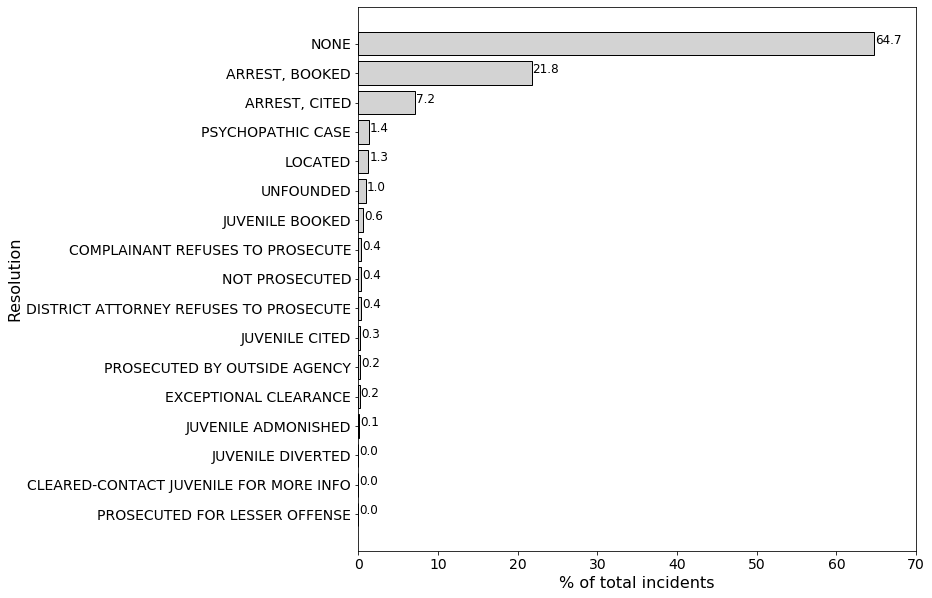

In [23]:
fig = plt.figure(figsize = (10,10))
ax  = fig.add_subplot(1,1,1)
plt.barh(unique_incidents_by_res['Resolution'].values[::-1],
        unique_incidents_by_res['Percent'].values[::-1], color = 'lightgray', edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('% of total incidents', fontsize = 16)
plt.ylabel('Resolution', fontsize = 16)

for i in range(len(unique_incidents_by_res['Resolution'].values[::-1])):
    plt.text(unique_incidents_by_res['Percent'].values[::-1][i]+0.1 , i , 
             round(unique_incidents_by_res['Percent'].values[::-1][i],1), fontsize = 12)

plt.xlim(0,70) 
plt.savefig ('../Plots/incidents/Percent_all_incidents_by_resolution.pdf', bbox_inches = 'tight')

Unfortunately about 65% of incidents have no resolutions. 
We will take a closer look at the ratio between resolved (all resolution types other than None) and non-resolved (resolution type None) incidents for different incident categories. 

In [24]:
unique_incidents.loc[unique_incidents['Resolution'].isin(['NONE']),'Resolved?'] = 0
unique_incidents.loc[~ unique_incidents['Resolution'].isin(['NONE']),'Resolved?'] = 1

In [25]:
unique_incidents_resolved = unique_incidents.loc[unique_incidents['Resolved?'] == 1]
unique_incidents_not_resolved = unique_incidents.loc[unique_incidents['Resolved?'] == 0]


In [26]:
unique_incidents_resolved_by_main_cat = unique_incidents_resolved.groupby(['Main_Category'])['IncidntNum'].count().sort_values(ascending = False).reset_index()
unique_incidents_resolved_by_main_cat.rename(columns = {'IncidntNum':'Count_resolved'}, inplace = True)


In [27]:
unique_incidents_not_resolved_by_main_cat = unique_incidents_not_resolved.groupby(['Main_Category'])['IncidntNum'].count().sort_values(ascending = False).reset_index()
unique_incidents_not_resolved_by_main_cat.rename(columns = {'IncidntNum':'Count_not_resolved'}, inplace = True)


In [28]:
unique_incidents_by_resolution_by_main_cat = unique_incidents_resolved_by_main_cat.merge(unique_incidents_not_resolved_by_main_cat)

In [29]:
unique_incidents_by_resolution_by_main_cat ['Total'] = unique_incidents_by_resolution_by_main_cat.sum(axis = 1)

In [30]:
unique_incidents_by_resolution_by_main_cat ['Count_resolved_Fraction'] = unique_incidents_by_resolution_by_main_cat ['Count_resolved']/unique_incidents_by_resolution_by_main_cat ['Total']
unique_incidents_by_resolution_by_main_cat ['Count_not_resolved_Fraction'] = unique_incidents_by_resolution_by_main_cat ['Count_not_resolved']/unique_incidents_by_resolution_by_main_cat ['Total']

In [31]:
unique_incidents_by_resolution_by_main_cat 

,Main_Category,Count_resolved,Count_not_resolved,Total,Count_resolved_Fraction,Count_not_resolved_Fraction
0,Other Non-Violent Incidents,428488,441223,869711,0.492679,0.507321
1,Property-related Incidents,101524,758598,860122,0.118034,0.881966
2,Other Violent Incidents,82434,114552,196986,0.418476,0.581524
3,Drug-related Incidents,79457,8260,87717,0.905834,0.094166
4,Alchohol-related Incidents,16904,2470,19374,0.872510,0.127490
5,Sexual-related Incidents,16766,7059,23825,0.703715,0.296285


In [32]:
unique_incidents_by_resolution_by_main_cat.sort_values(['Count_resolved_Fraction'], inplace = True)

In [33]:
unique_incidents_by_resolution_by_main_cat['Count_not_resolved_Fraction']

1    0.881966
2    0.581524
0    0.507321
5    0.296285
4    0.127490
3    0.094166
Name: Count_not_resolved_Fraction, dtype: float64

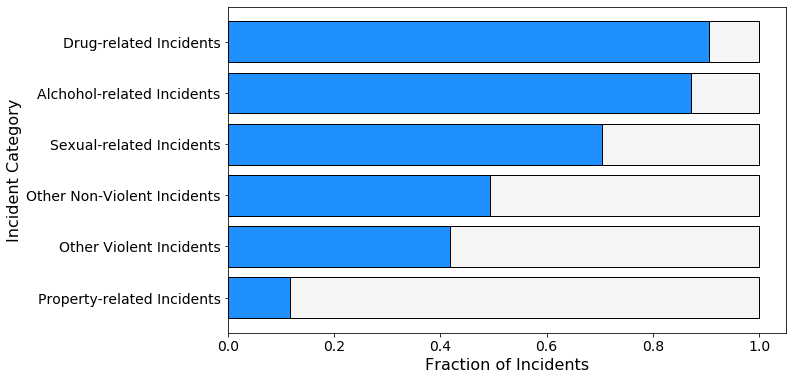

In [34]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)
plt.barh(unique_incidents_by_resolution_by_main_cat['Main_Category'], unique_incidents_by_resolution_by_main_cat['Count_not_resolved_Fraction']+\
         unique_incidents_by_resolution_by_main_cat['Count_resolved_Fraction'],color = 'whitesmoke',label = 'not resolved',edgecolor = 'black')
plt.barh(unique_incidents_by_resolution_by_main_cat['Main_Category'],unique_incidents_by_resolution_by_main_cat['Count_resolved_Fraction'],
         color = 'dodgerblue',label = 'resolved', edgecolor = 'black')

ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Fraction of Incidents', fontsize = 16)
plt.ylabel('Incident Category', fontsize = 16)
plt.savefig ('../Plots/incidents/Percent_all_incidents_by_Maincat_by_resolution.pdf', bbox_inches = 'tight')


As shown in figure above, about 90% of Drug related incidents and more than 80% of Alchohol-related incidents are resolved in a way. However, more than 50% of other violent incidents and more than 80% of property-related incidents remained unresolved.

## Hourly Distribution of Incidents

In [35]:
unique_incidents.columns

Index(['IncidntNum', 'Date Time', 'Category', 'DayOfWeek', 'X', 'Y',
       'Resolution', 'Count', 'Main_Category', 'Resolved?'],
      dtype='object')

We start with looking at diurnal patterns in distribution of incidents in different categories

In [36]:
unique_incidents['Hour'] = unique_incidents['Date Time'].dt.hour

In [37]:
unique_incidents_by_main_cat_by_hour = unique_incidents.groupby(['Main_Category','Hour'])['Date Time'].count().unstack()
unique_incidents_by_main_cat_by_hour['total'] = unique_incidents_by_main_cat_by_hour.sum(axis = 1)
unique_incidents_by_main_cat_by_hour = unique_incidents_by_main_cat_by_hour.div(unique_incidents_by_main_cat_by_hour['total'], axis = 0)*100
unique_incidents_by_main_cat_by_hour.drop(['total'], axis = 1, inplace = True)

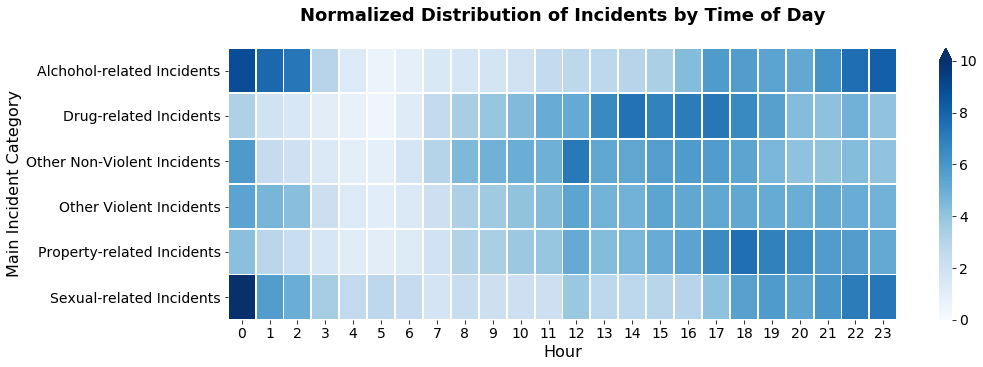

In [38]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,1,1)
cbar_kws = {
            'extend':'max'
           }
sns.heatmap(unique_incidents_by_main_cat_by_hour , cmap="Blues",linewidth = 1, cbar_kws = cbar_kws, vmin=0,vmax = 10)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel ('Hour' , fontsize = 16)
plt.ylabel ('Main Incident Category', fontsize = 16)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Normalized Distribution of Incidents by Time of Day\n', fontsize = 18 , fontweight = 'bold')
plt.savefig ('../Plots/incidents/Hourly_Distribution_Incidents_Main_Cat.pdf', bbox_inches = 'tight')

As shown in figure above, Alchohol-related inciddents generally occur later in the day especially between 10 pm to 3 am. Most of drug-related incidents occurred in the afternoon between 1 pm to 7pm. Non-Violent incidents generally occurred during the day between 8 am to 7 pm, while violent crimes occurred mostly during 12 pm to 3 pm. The occurrence of Property-related incidents were largest in the evening between 5pm to 10 pm. Sexual-related events were more frequent in the evening and late night between 5 pm to 3 am. Overall, safest hour of the day were around 5 am in San Francisco. 

## What was the most common time of day for a DRUG/NARCOTIC incident to occur in 2017?

In [39]:
unique_incidents_2017_drug = unique_incidents.loc[(unique_incidents['Category'] == 'DRUG/NARCOTIC')&(unique_incidents['Date Time'].dt.year == 2017)]

In [40]:
unique_incidents_2017_drug

,IncidntNum,Date Time,Category,DayOfWeek,X,Y,Resolution,Count,Main_Category,Resolved?,Hour
10,170784869,2017-09-26 01:38:00,DRUG/NARCOTIC,Tuesday,-122.405863,37.798023,"ARREST, BOOKED",8,Drug-related Incidents,1.0,1
12,170377044,2017-05-08 10:34:00,DRUG/NARCOTIC,Monday,-122.425731,37.777911,"ARREST, BOOKED",7,Drug-related Incidents,1.0,10
13,170570583,2017-07-14 23:14:00,DRUG/NARCOTIC,Friday,-122.431545,37.759434,"ARREST, BOOKED",7,Drug-related Incidents,1.0,23
57,170304730,2017-04-13 23:10:00,DRUG/NARCOTIC,Thursday,-122.411303,37.785536,"ARREST, BOOKED",6,Drug-related Incidents,1.0,23
62,171028482,2017-12-20 18:51:00,DRUG/NARCOTIC,Wednesday,-122.420026,37.783050,"ARREST, BOOKED",6,Drug-related Incidents,1.0,18
...,...,...,...,...,...,...,...,...,...,...,...
1561294,170104217,2017-02-06 11:27:00,DRUG/NARCOTIC,Monday,-122.457869,37.739576,JUVENILE BOOKED,1,Drug-related Incidents,1.0,11
1561367,170104320,2017-02-06 12:35:00,DRUG/NARCOTIC,Monday,-122.419815,37.765843,"ARREST, BOOKED",1,Drug-related Incidents,1.0,12
1561386,170104530,2017-02-06 12:45:00,DRUG/NARCOTIC,Monday,-122.391425,37.777873,"ARREST, BOOKED",1,Drug-related Incidents,1.0,12
1561462,170103407,2017-02-06 02:05:00,DRUG/NARCOTIC,Monday,-122.406539,37.756486,NONE,1,Drug-related Incidents,0.0,2


In [41]:
unique_incidents_2017_drug_byHour = unique_incidents_2017_drug.groupby('Hour')['IncidntNum'].count()


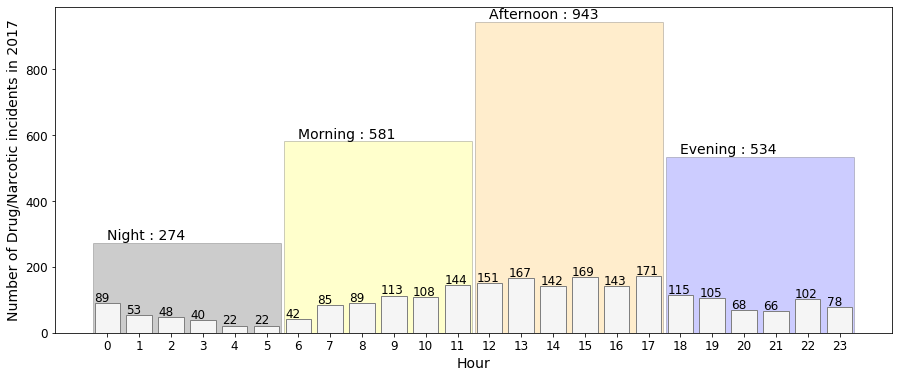

In [42]:
rotation = 0
xx = np.arange(len(unique_incidents_2017_drug_byHour))
yy = unique_incidents_2017_drug_byHour.values
x_label = 'Hour'
y_label = 'Number of Drug/Narcotic incidents in 2017'

fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(1,1,1)

Time_of_Day = ['Night','Morning','Afternoon','Evening']
Time_of_Day_Start = [0,6,12,18]
Time_of_Day_End = [5,11,17,23]
Time_of_Day_Drug_Narcoic = []

for i in range(len(Time_of_Day)):
    Time_of_Day_Drug_Narcoic.append(unique_incidents_2017_drug_byHour.iloc[Time_of_Day_Start[i]:Time_of_Day_End[i]+1].sum())

colors = ['black','yellow','orange','blue']
for i in range(len(Time_of_Day)):
    plt.bar((Time_of_Day_Start[i]+Time_of_Day_End[i])/2, Time_of_Day_Drug_Narcoic[i], width = 5.9, alpha = 0.2, color = colors[i],edgecolor = 'black')
    plt.text((Time_of_Day_Start[i]+Time_of_Day_End[i])/2-2.5 , Time_of_Day_Drug_Narcoic[i]+10 , Time_of_Day[i]+' : '+str(Time_of_Day_Drug_Narcoic[i]), fontsize = 14)

plt.bar (xx , yy , color = 'whitesmoke',edgecolor = 'gray')
for i in range(len(xx)):
    plt.text(xx[i]-0.4 , yy[i]+5 , str(round(yy[i],1)), fontsize = 12)
plt.xlabel(x_label, fontsize = 14)
plt.ylabel(y_label, fontsize = 14)
plt.xticks(np.arange(0,24),np.arange(0,24))
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig ('../Plots/incidents/Hourly_Distribution_Drugs_2017.pdf', bbox_inches = 'tight')


As shown above, Drug/Narcotics incidents are more frequent in the afternoon between 12 pm to 5 pm.

## Daily Distribution of Incidents

In [43]:
unique_incidents['DayOfWeek_numeric'] = unique_incidents['Date Time'].apply(lambda x: x.weekday()) ### Monday = 0, Sunday = 6

unique_incidents_by_type_by_DayOfWeek = unique_incidents.groupby(['Main_Category','DayOfWeek_numeric'])['IncidntNum'].count().unstack()
unique_incidents_by_type_by_DayOfWeek['total'] = unique_incidents_by_type_by_DayOfWeek.sum(axis = 1)
unique_incidents_by_type_by_DayOfWeek.sort_values('total', inplace = True, ascending = False)
unique_incidents_by_type_by_DayOfWeek_Fraction = unique_incidents_by_type_by_DayOfWeek.div(unique_incidents_by_type_by_DayOfWeek['total'], axis = 0)*100
unique_incidents_by_type_by_DayOfWeek_Fraction.drop(['total'], axis = 1, inplace = True)


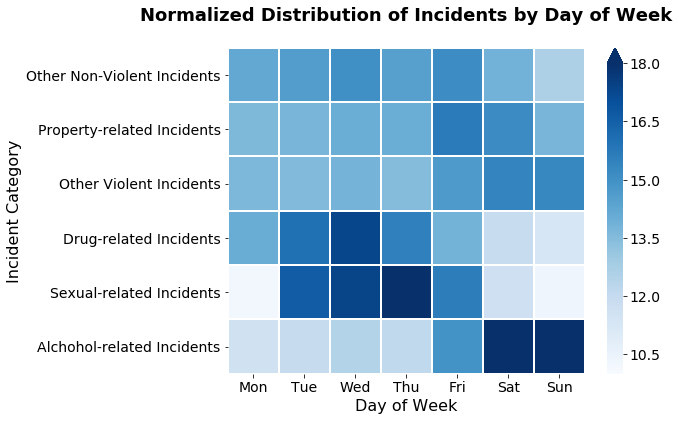

In [44]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
cbar_kws = {
            'extend':'max'
           }
sns.heatmap(unique_incidents_by_type_by_DayOfWeek_Fraction , cmap="Blues",linewidth = 1, cbar_kws = cbar_kws,
           vmin = 10, vmax = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel ('Day of Week' , fontsize = 16)
plt.ylabel ('Incident Category', fontsize = 16)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Normalized Distribution of Incidents by Day of Week\n', fontsize = 18 , fontweight = 'bold')
plt.xticks ([0.5,1.5,2.5,3.5,4.5,5.5,6.5], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.savefig ('../Plots/incidents/Daily_Distribution_Incidents_Main_Cat.pdf', bbox_inches = 'tight')

## Monthly Distribution of Incidents

In [45]:
unique_incidents_complete_month = unique_incidents.loc[unique_incidents['Date Time'].dt.year<2018] ### only including complete years
unique_incidents_complete_month['Month'] = unique_incidents_complete_month['Date Time'].dt.month 

unique_incidents_by_type_by_Month = unique_incidents_complete_month.groupby(['Main_Category','Month'])['IncidntNum'].count().unstack()
unique_incidents_by_type_by_Month['total'] = unique_incidents_by_type_by_Month.sum(axis = 1)
unique_incidents_by_type_by_Month.sort_values('total', inplace = True, ascending = False)
unique_incidents_by_type_by_Month_Fraction = unique_incidents_by_type_by_Month.div(unique_incidents_by_type_by_Month['total'], axis = 0)*100
unique_incidents_by_type_by_Month_Fraction.drop(['total'], axis = 1, inplace = True)

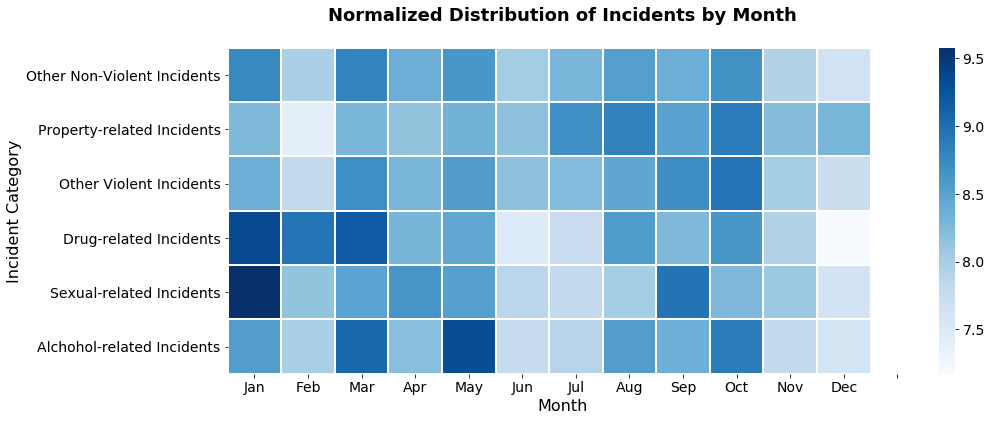

In [46]:
fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(unique_incidents_by_type_by_Month_Fraction , cmap="Blues",linewidth = 1)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel ('Month' , fontsize = 16)
plt.ylabel ('Incident Category', fontsize = 16)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Normalized Distribution of Incidents by Month\n', fontsize = 18 , fontweight = 'bold')
plt.xticks ([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5], 
            ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.savefig ('../Plots/incidents/Monthly_Distribution_Incidents_Main_Cat.pdf', bbox_inches = 'tight')

## Distribution of Incidents by Neighborhood

In this section, we map X Y locations of incidents to neighborhood polygons which we downloaded from https://data.sfgov.org/. This helps us find out which neighborhoods in San Francisco have the most incidents.

In [47]:
#### reading in the shapefile
sfnhoods = gp.read_file('../data/Analysis Neighborhoods/geo_export_babbf797-0d9b-407f-a79c-eb11d24002a8.dbf')

#### converting the X Y values into coordinates
unique_incidents ['Coordinates'] = (unique_incidents[['X','Y']].apply(tuple, axis = 1).apply(Point))

#### converting the incidents dataframe into a geodataframe
unique_incidents_geo = gp.GeoDataFrame(unique_incidents, geometry = 'Coordinates')

#### making sure that our incidents geodataframe has the same projection as the sfnhoods dataframe 
unique_incidents_geo.crs = sfnhoods.crs

#### now we merge the sfnhoods dataframe to our incidents dataframe which will add a column nhood that shows the neighborhood of each incident
unique_incidents_geo = gp.sjoin(unique_incidents_geo, sfnhoods)


Let's look and see which neighborhood has the largest number of incidents

In [48]:
unique_incidents_geo_neighborhoods = unique_incidents_geo.groupby('nhood')['IncidntNum'].count().sort_values(ascending = False)
unique_incidents_geo_neighborhoods

nhood
Mission                           242254
South of Market                   241290
Tenderloin                        235951
Financial District/South Beach    141729
Bayview Hunters Point             135181
Western Addition                   73670
Sunset/Parkside                    60817
Nob Hill                           60531
Castro/Upper Market                58038
North Beach                        50137
Hayes Valley                       48754
Bernal Heights                     42918
Marina                             42570
West of Twin Peaks                 41580
Haight Ashbury                     39230
Excelsior                          39008
Outer Richmond                     38267
Potrero Hill                       36951
Pacific Heights                    36034
Outer Mission                      33311
Chinatown                          33202
Oceanview/Merced/Ingleside         31521
Russian Hill                       31476
Visitacion Valley                  27797
Lone Mount

Let's look at the map of total incidents per neighborhood, 2003-01-01 to 2018-05-15

<Figure size 720x720 with 0 Axes>

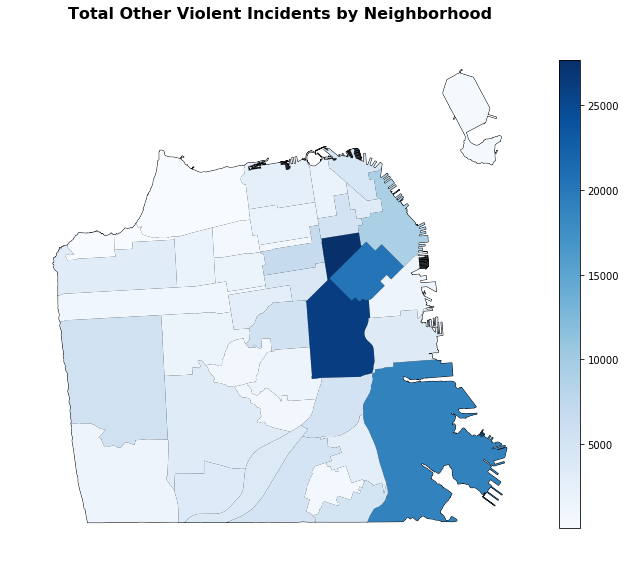

<Figure size 720x720 with 0 Axes>

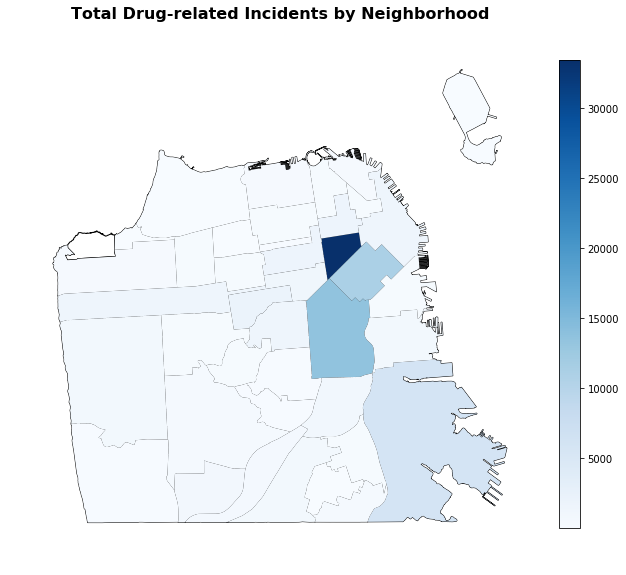

<Figure size 720x720 with 0 Axes>

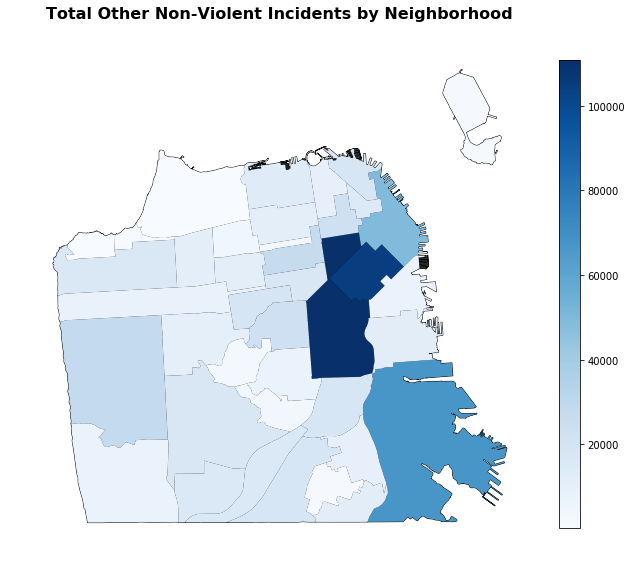

<Figure size 720x720 with 0 Axes>

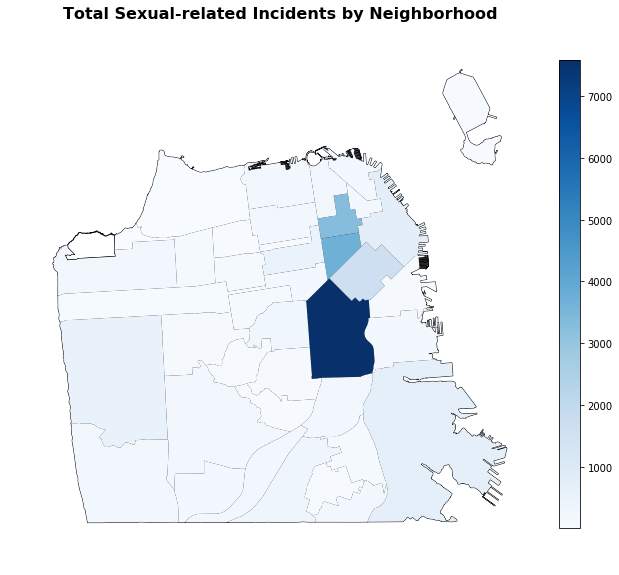

<Figure size 720x720 with 0 Axes>

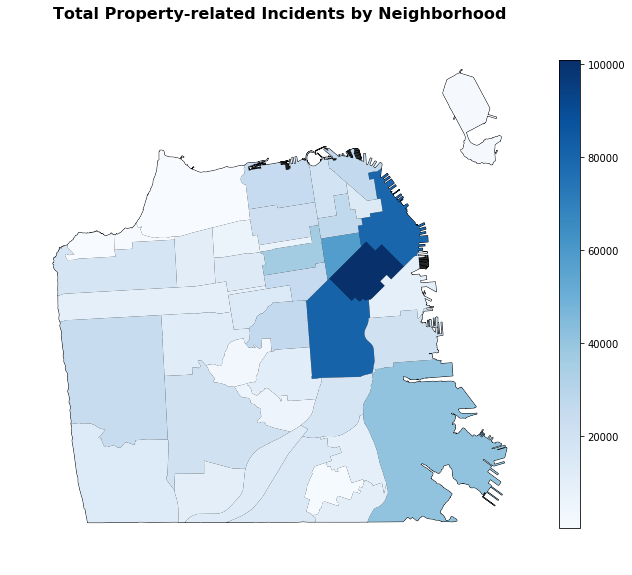

<Figure size 720x720 with 0 Axes>

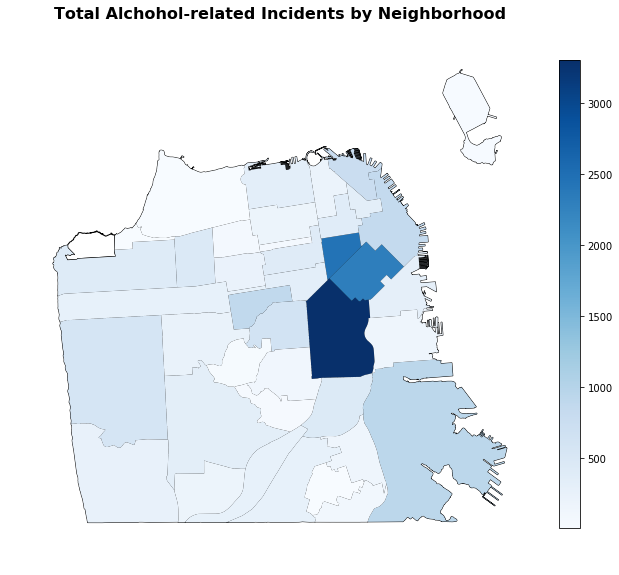

In [49]:
counter = 1
for cat in unique_incidents['Main_Category'].unique():
    
    fig = plt.figure(figsize = (10,10))
    aa = unique_incidents_geo.loc[unique_incidents_geo['Main_Category'] == cat]['nhood'].value_counts().to_frame().reset_index().rename(columns = {'nhood':'Incidents'})
    aa.rename(columns = {'index':'nhood'}, inplace = True)                                          
                                              
    geodf = gp.GeoDataFrame(aa.merge (sfnhoods))
    
    ax = gplt.choropleth(geodf, projection = gcrs.LambertConformal(), hue='Incidents', 
                         cmap = 'Blues',  linewidth = 0, figsize = (10,10))
    gplt.polyplot(sfnhoods.geometry, projection = gcrs.LambertConformal(),linewidth = 1,
                       edgecolor = 'k', ax = ax)
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.18, 0.03, 0.65])
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=geodf['Incidents'].min(), vmax=geodf['Incidents'].max()))
    sm._A = []
    fig.colorbar(sm, cax=cax, shrink = 0.1)
    
    ax.set_title('Total '+cat+' by Neighborhood', fontweight = 'bold', fontsize = 16)
    counter += 1
    plt.savefig ('../Plots/incidents/Spatial_Distribution_Incidents_'+cat+'.pdf', bbox_inches = 'tight')

    

Now as an example, let's see how spatial distribution and volume of Drug-related incidents have changed from 2003 to 2018.

In [50]:
unique_incidents_geo = unique_incidents_geo.loc[unique_incidents_geo['Date Time'].dt.year<2018]

In [51]:
cat = 'Drug-related Incidents'

years = np.arange(2003,2018)
annual_unique_drug_related_incidents_dict = dict()
Max_annual_incidents = []
Min_annual_incidents = []

for yy in years:
    aa = unique_incidents_geo.loc[(unique_incidents_geo['Main_Category'] == cat)&(unique_incidents_geo['Date Time'].dt.year == yy)]['nhood'].value_counts().to_frame().reset_index().rename(columns = {'nhood':'Incidents'})
    aa.rename(columns = {'index':'nhood'}, inplace = True)                                                                                        
    geodf = gp.GeoDataFrame(aa.merge (sfnhoods))    
    Max_annual_incidents.append(geodf['Incidents'].max())
    Min_annual_incidents.append(geodf['Incidents'].min())
    annual_unique_drug_related_incidents_dict[yy] = geodf


<Figure size 720x720 with 0 Axes>

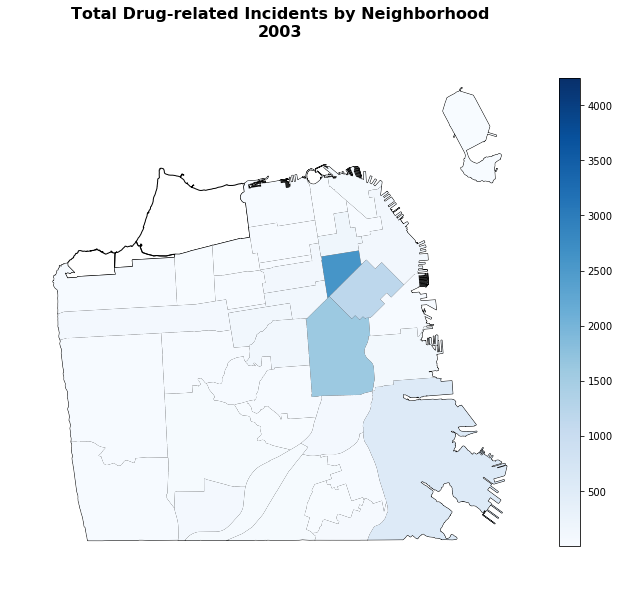

<Figure size 720x720 with 0 Axes>

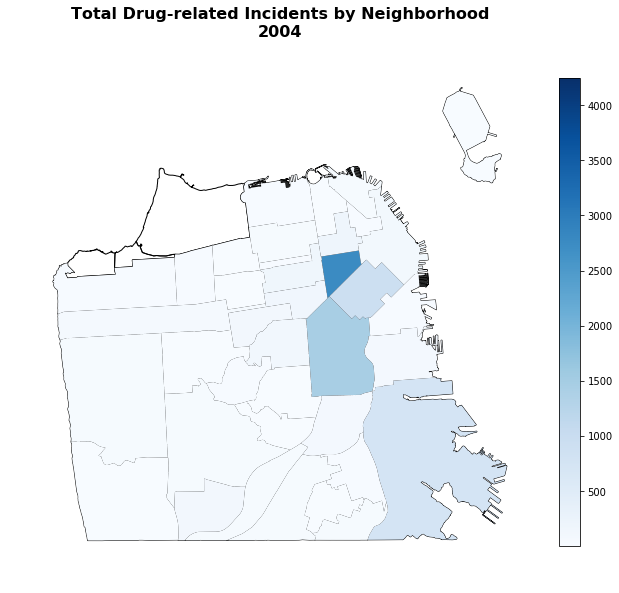

<Figure size 720x720 with 0 Axes>

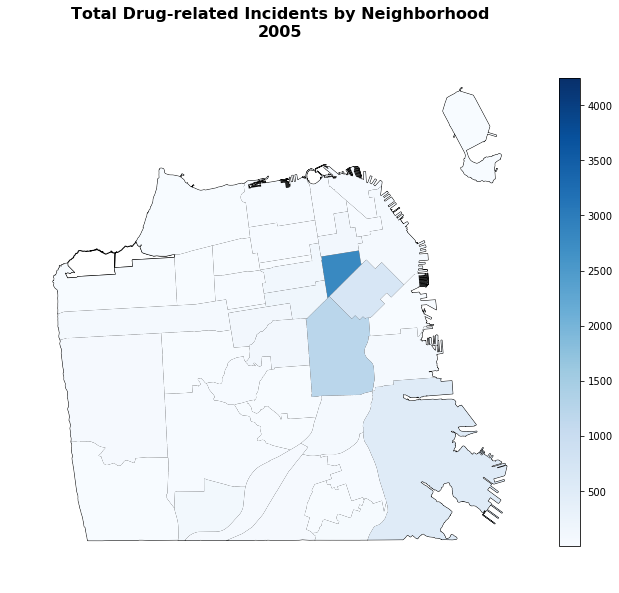

<Figure size 720x720 with 0 Axes>

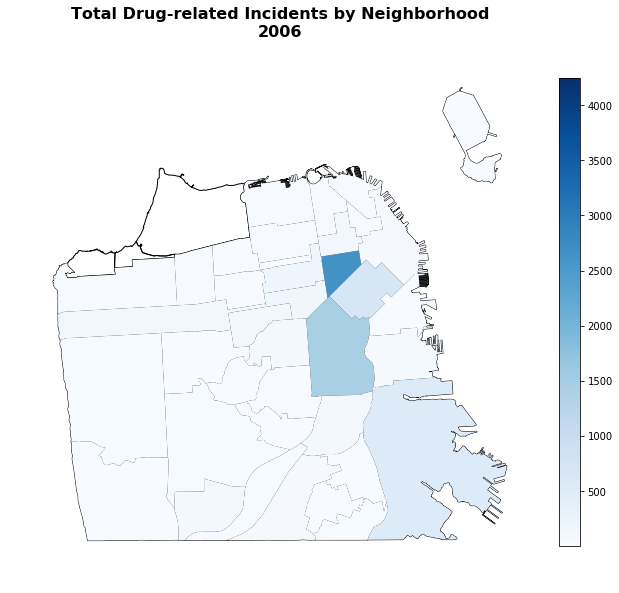

<Figure size 720x720 with 0 Axes>

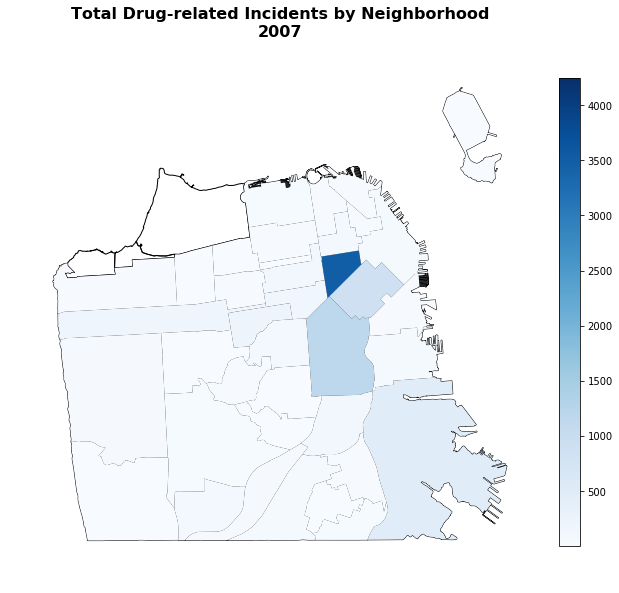

<Figure size 720x720 with 0 Axes>

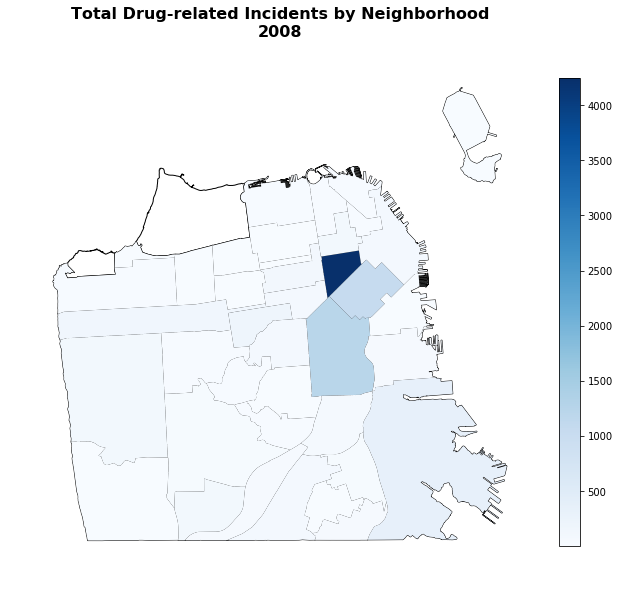

<Figure size 720x720 with 0 Axes>

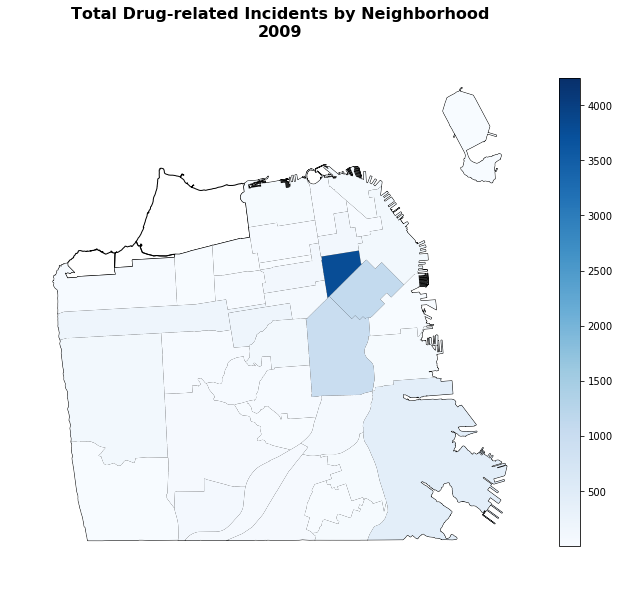

<Figure size 720x720 with 0 Axes>

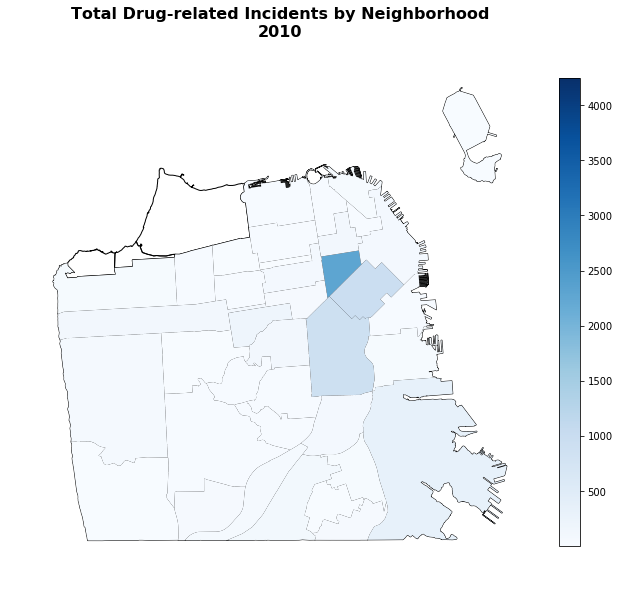

<Figure size 720x720 with 0 Axes>

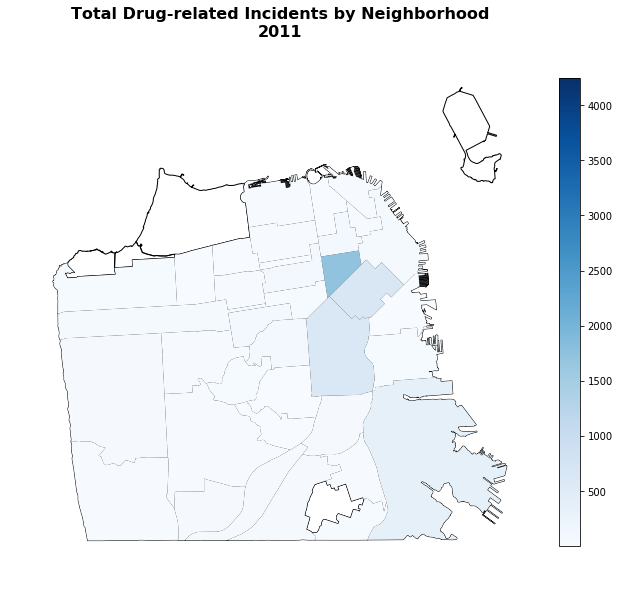

<Figure size 720x720 with 0 Axes>

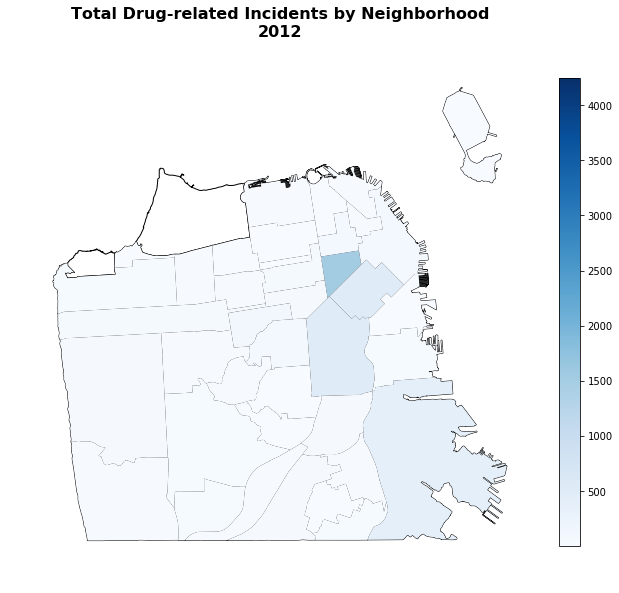

<Figure size 720x720 with 0 Axes>

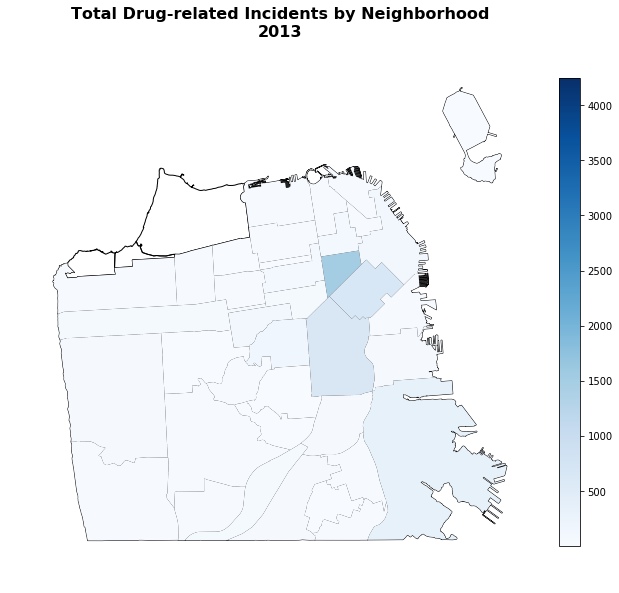

<Figure size 720x720 with 0 Axes>

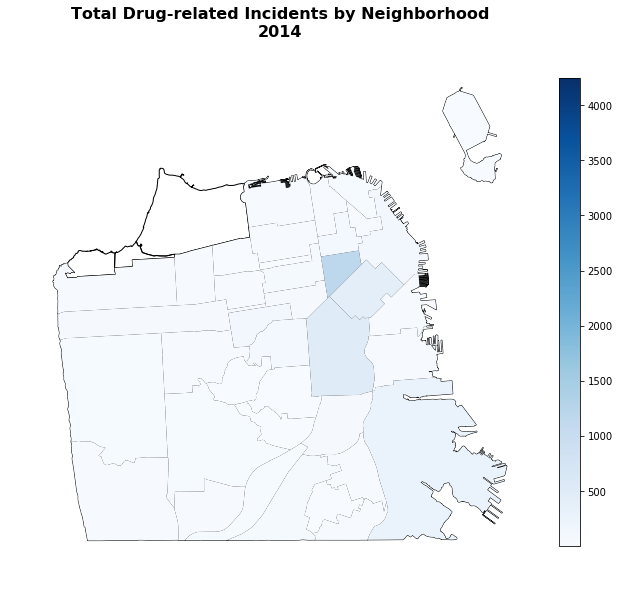

<Figure size 720x720 with 0 Axes>

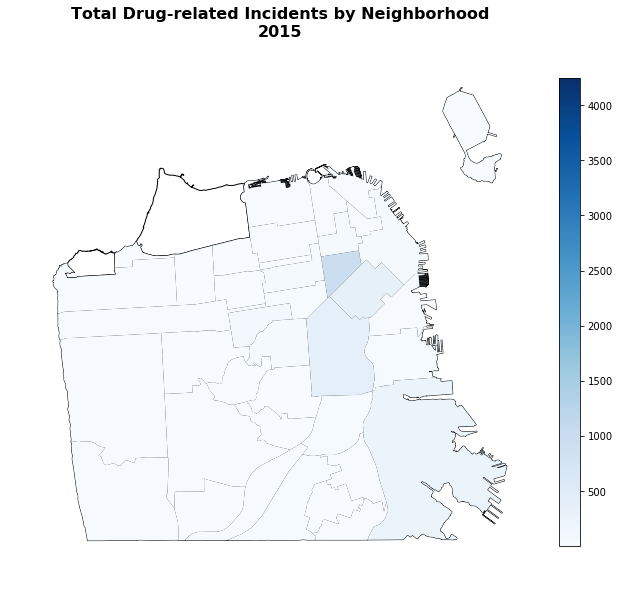

<Figure size 720x720 with 0 Axes>

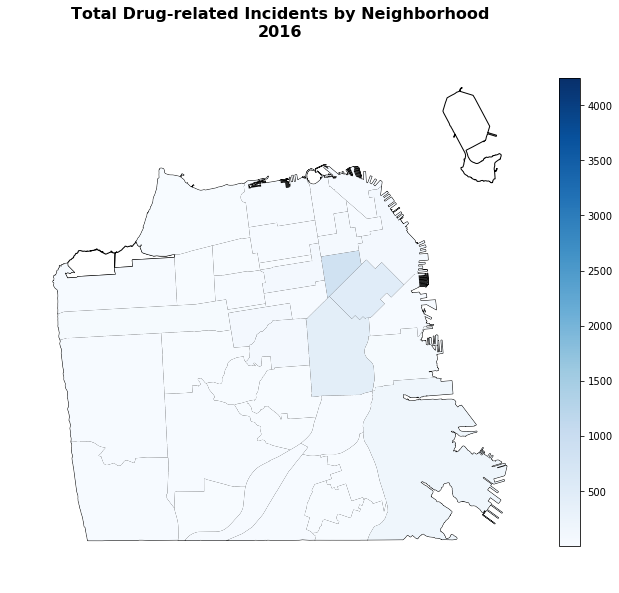

<Figure size 720x720 with 0 Axes>

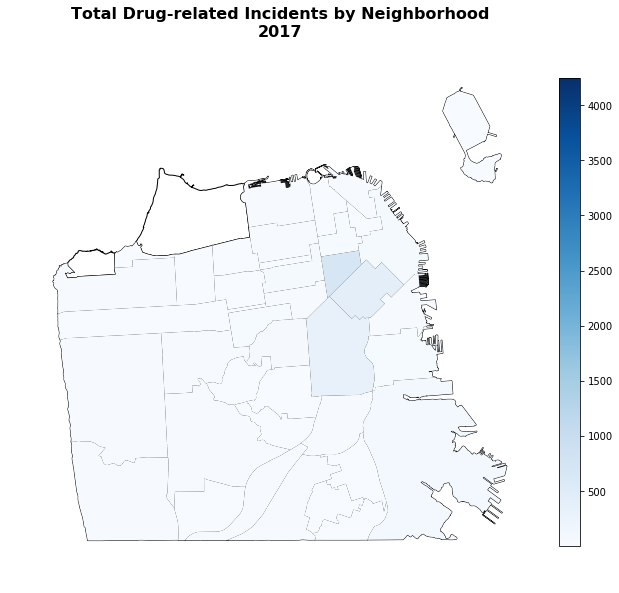

In [52]:
for yy in years:
    fig = plt.figure(figsize = (10,10))
    geodf = annual_unique_drug_related_incidents_dict[yy]
    
#     divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    divnorm = plt.Normalize(vmin=np.min(Min_annual_incidents), vmax=np.max(Max_annual_incidents))
    ax = gplt.choropleth(geodf, projection = gcrs.LambertConformal(), hue='Incidents', 
                         cmap = 'Blues',  linewidth = 0, figsize = (10,10), norm = divnorm)
    
    gplt.polyplot(sfnhoods.geometry, projection = gcrs.LambertConformal(),linewidth = 1,
                       edgecolor = 'k', ax = ax)
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.18, 0.03, 0.65])
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=divnorm)
    sm._A = []
    fig.colorbar(sm, cax=cax, shrink = 0.1)
    
    ax.set_title('Total '+cat+' by Neighborhood\n'+str(yy), fontweight = 'bold', fontsize = 16)
    counter += 1
    plt.savefig ('../Plots/incidents/Yearly_Spatial_Distribution_Incidents_Drugs_'+str(yy)+'.pdf', bbox_inches = 'tight')
    
    